# **Deep Learning Lab: Transfer Learning**

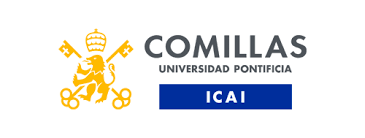

***

## Import packages

In [1]:
from cnn import CNN
import torchvision
from cnn import load_data
from cnn import load_model_weights
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import random
import wandb

---
## **Model and data loading**

In [ ]:
# Pytorch has many pre-trained models that can be used for transfer learning
classification_models = torchvision.models.list_models(module=torchvision.models)
print(classification_models)

['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'googlenet', 'inception_v3', 'maxvit_t', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_400mf', 'regnet_x_800mf', 'regnet_x_8gf', 'regnet_y_128gf', 'regnet_y_16gf', 'regnet_y_1_6gf', 'regnet_y_32gf', 'regnet_y_3_2gf', 'regnet_y_400mf', 'regnet_y_800mf', 'regnet_y_8gf', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext101_64x4d', 'resnext50_32x4d', 'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 'shufflenet_v2_x1_5', 'shufflenet_v2_x2_0', 'squeezenet1_0

In [ ]:
# Load data and model
train_dir = "../dataset/training"
valid_dir = "../dataset/validation"

train_loader, valid_loader, num_classes = load_data(
    train_dir, valid_dir, batch_size=32, img_size=224
)  # ResNet50 requires 224x224 images
model = CNN(torchvision.models.resnet50(weights="DEFAULT"), num_classes)

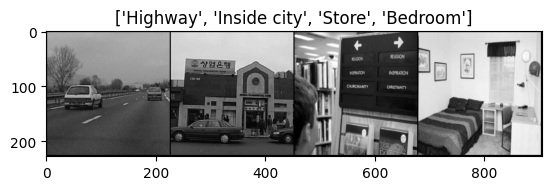

In [ ]:
# Visualize a few images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a few random images
random_indices = np.random.choice(len(valid_loader.dataset), size=4, replace=False)
inputs = []
classes = []
for i in random_indices:
    inputs.append(valid_loader.dataset[i][0])
    classes.append(valid_loader.dataset[i][1])
out = torchvision.utils.make_grid(inputs)
classnames = train_loader.dataset.classes
imshow(out, title=[classnames[x] for x in classes])

---
## **Train**

In [5]:
# Parameters
learning_rate = 1e-4
epochs = 2

#### **Configuración W&B**

In [ ]:
# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="jcriego-prsoria-angelvt",
    # Set the wandb project where this run will be logged.
    project="Understanding-CNNs",
    # name="model_1",  # Aquí defines el nombre del run
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": learning_rate,
        "architecture": "CNN",
        "dataset": "CIFAR-100",
        "epochs": epochs,
    },
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jcriego (jcriego-prsoria-angelvt) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# Train the model

# Watch the model (W&B)
# wandb.watch(model, log="all")

# Define the loss function and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Train the model
for epoch in range(epochs):

    # Fase de entrenamiento
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_train = 0

    # Iterate over training data
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        total_train += inputs.size(0)

    # Loss and accuracy
    epoch_train_loss = running_loss / total_train
    epoch_train_acc = running_corrects.double() / total_train

    # Registro de métricas en wandb
    run.log(
        {
            "epoch": epoch + 1,
            "train_loss": epoch_train_loss,
            "train_accuracy": epoch_train_acc.item(),
        }
    )

    print(
        f"Epoch {epoch+1}/{epochs} - "
        f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} - "
    )

# Guarda el modelo entrenado
model.save_model("resnet50-1epoch")

Epoch 1/2 - Train Loss: 2.6425, Train Acc: 0.2807 - 


In [ ]:
# Train the model
"""
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
history = model.train_model(train_loader, valid_loader, optimizer, criterion, epochs=1)

model.save_model('resnet50-1epoch')'
"""

---
## **Predict**

#### Load model

In [ ]:
# Load model
model_weights = load_model_weights("resnet50-1epoch")
my_trained_model = CNN(torchvision.models.resnet50(weights="DEFAULT"), num_classes)
my_trained_model.load_state_dict(model_weights)

---
## **Results**

In [ ]:
predicted_labels = my_trained_model.predict(valid_loader)

In [ ]:
# Get a few random images
random_indices = np.random.choice(len(valid_loader.dataset), size=4, replace=False)
inputs = []
classes = []
for i in random_indices:
    inputs.append(valid_loader.dataset[i][0])
    classes.append(predicted_labels[i])

out = torchvision.utils.make_grid(inputs)
classnames = train_loader.dataset.classes
imshow(out, title=[classnames[x] for x in classes])